# Maximum Mean Discrepancy drift detector on CIFAR-10

### Method

The [Maximum Mean Discrepancy (MMD)](http://jmlr.csail.mit.edu/papers/v13/gretton12a.html) detector is a kernel-based method for multivariate 2 sample testing. The MMD is a distance-based measure between 2 distributions *p* and *q* based on the mean embeddings $\mu_{p}$ and $\mu_{q}$ in a reproducing kernel Hilbert space $F$:

$$
MMD(F, p, q) = || \mu_{p} - \mu_{q} ||^2_{F}
$$

We can compute unbiased estimates of $MMD^2$ from the samples of the 2 distributions after applying the kernel trick. We use by default a [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), but users are free to pass their own kernel of preference to the detector. We obtain a $p$-value via a [permutation test](https://en.wikipedia.org/wiki/Resampling_(statistics)) on the values of $MMD^2$. This method is also described in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953).

### Backend

The method is implemented in both the *PyTorch* and *TensorFlow* frameworks with support for CPU and GPU. Various preprocessing steps are also supported out-of-the box in Alibi Detect for both frameworks and illustrated throughout the notebook. Alibi Detect does however not install PyTorch for you. Check the [PyTorch docs](https://pytorch.org/) how to do this. 

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from alibi_detect.cd import MMDDrift
from alibi_detect.models.tensorflow.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

### Load data

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [4]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the *H<sub>0</sub>* of the MMD test. We also split the corrupted data by corruption type:

In [5]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [6]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [7]:
n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

We can visualise the same instance for each corruption type:

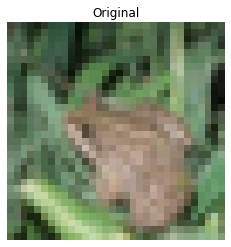

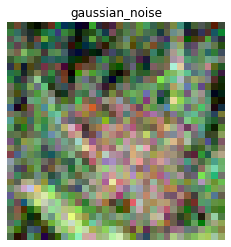

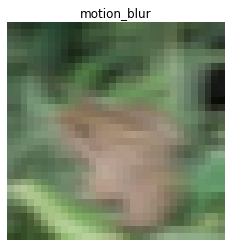

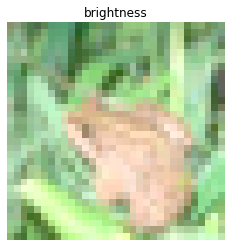

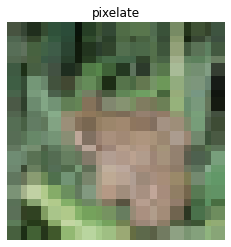

In [8]:
i = 4

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [9]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


Given the drop in performance, it is important that we detect the harmful data drift!

### Detect drift with TensorFlow backend

First we try a drift detector using the *TensorFlow* framework for both the preprocessing and the *MMD* computation steps.

We are trying to detect data drift on high-dimensional (*32x32x3*) data using a multivariate MMD permutation test. It therefore makes sense to apply dimensionality reduction first. Some dimensionality reduction methods also used in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/pdf/1810.11953.pdf) are readily available: a randomly initialized encoder (**UAE** or Untrained AutoEncoder in the paper), **BBSDs** (black-box shift detection using the classifier's softmax outputs) and **PCA** (using `scikit-learn`).

#### Random encoder

First we try the randomly initialized encoder:

In [10]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
cd = MMDDrift(X_ref, backend='tensorflow', p_val=.05, 
              preprocess_fn=preprocess_fn, n_permutations=100)

# we can also save/load an initialised detector
filepath = 'my_path'  # change to directory where detector is saved
save_detector(cd, filepath)
cd = load_detector(filepath)

Directory my_path/model does not exist and is now created.


`sigma` is specified for the kernel and `configure_kernel_from_x_ref` is set to True. `sigma` argument takes priority over `configure_kernel_from_x_ref` (set to False).


Let's check whether the detector thinks drift occurred on the different test sets and time the prediction calls:

In [11]:
from timeit import default_timer as timer

labels = ['No!', 'Yes!']

def make_predictions(cd, x_h0, x_corr, corruption):
    t = timer()
    preds = cd.predict(x_h0)
    dt = timer() - t
    print('No corruption')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print(f'p-value: {preds["data"]["p_val"]:.3f}')
    print(f'Time (s) {dt:.3f}')
    
    if isinstance(x_corr, list):
        for x, c in zip(x_corr, corruption):
            t = timer()
            preds = cd.predict(x)
            dt = timer() - t
            print('')
            print(f'Corruption type: {c}')
            print('Drift? {}'.format(labels[preds['data']['is_drift']]))
            print(f'p-value: {preds["data"]["p_val"]:.3f}')
            print(f'Time (s) {dt:.3f}')

In [12]:
make_predictions(cd, X_h0, X_c, corruption)

No corruption
Drift? No!
p-value: 0.680
Time (s) 42.787

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 131.883

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 159.807

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 175.093

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 175.855


As expected, drift was only detected on the corrupted datasets.

#### BBSDs

For **BBSDs**, we use the classifier's softmax outputs for black-box shift detection. This method is based on [Detecting and Correcting for Label Shift with Black Box Predictors](https://arxiv.org/abs/1802.03916). The ResNet classifier is trained on data standardised by instance so we need to rescale the data.

In [13]:
X_ref_bbsds = scale_by_instance(X_ref)
X_h0_bbsds = scale_by_instance(X_h0)
X_c_bbsds = [scale_by_instance(X_c[i]) for i in range(n_corr)]

Initialisation of the drift detector. Here we use the output of the softmax layer to detect the drift, but other hidden layers can be extracted as well by setting *'layer'* to the index of the desired hidden layer in the model:

In [14]:
from alibi_detect.cd.tensorflow import HiddenOutput

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=HiddenOutput(clf, layer=-1), batch_size=128)

# initialise drift detector
cd = MMDDrift(X_ref_bbsds, backend='tensorflow', p_val=.05, 
              preprocess_fn=preprocess_fn, n_permutations=100)

In [15]:
make_predictions(cd, X_h0_bbsds, X_c_bbsds, corruption)

No corruption
Drift? No!
p-value: 0.440
Time (s) 83.564

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 235.984

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 250.503

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 390.384

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 326.660


Again drift is only flagged on the perturbed data.

### Detect drift with PyTorch backend

We can do the same thing using the *PyTorch* backend. We illustrate this using the randomly initialized encoder as preprocessing step:

In [16]:
import torch
import torch.nn as nn

# set random seed and device
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Since our *PyTorch* encoder expects the images in a *(batch size, channels, height, width)* format, we transpose the data:

In [17]:
def permute_c(x):
    return np.transpose(x.astype(np.float32), (0, 3, 1, 2))

X_ref_pt = permute_c(X_ref)
X_h0_pt = permute_c(X_h0)
X_c_pt = [permute_c(xc) for xc in X_c]
print(X_ref_pt.shape, X_h0_pt.shape, X_c_pt[0].shape)

(5000, 3, 32, 32) (5000, 3, 32, 32) (10000, 3, 32, 32)


In [18]:
from alibi_detect.cd.pytorch import preprocess_drift

# define encoder
encoder_net = nn.Sequential(
    nn.Conv2d(3, 64, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(64, 128, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Conv2d(128, 512, 4, stride=2, padding=0),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(2048, encoding_dim)
).to(device).eval()

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, device=device, batch_size=512)

# initialise drift detector
cd = MMDDrift(X_ref_pt, backend='pytorch', p_val=.05, 
              preprocess_fn=preprocess_fn, n_permutations=100)

No GPU detected, fall back on CPU.


In [19]:
make_predictions(cd, X_h0_pt, X_c_pt, corruption)

No corruption
Drift? No!
p-value: 0.730
Time (s) 84.144

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 318.372

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 292.758

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 288.507

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 217.628


The drift detector will attempt to use the GPU if available and otherwise falls back on the CPU. We can also explicitly specify the device. Let's compare the GPU speed up with the CPU implementation:

In [20]:
device = torch.device('cpu')
preprocess_fn = partial(preprocess_drift, model=encoder_net.to(device), 
                        device=device, batch_size=512)

cd = MMDDrift(X_ref_pt, backend='pytorch', preprocess_fn=preprocess_fn, device='cpu')

In [21]:
make_predictions(cd, X_h0_pt, X_c_pt, corruption)

No corruption
Drift? No!
p-value: 0.670
Time (s) 95.616

Corruption type: gaussian_noise
Drift? Yes!
p-value: 0.000
Time (s) 217.482

Corruption type: motion_blur
Drift? Yes!
p-value: 0.000
Time (s) 234.355

Corruption type: brightness
Drift? Yes!
p-value: 0.000
Time (s) 279.831

Corruption type: pixelate
Drift? Yes!
p-value: 0.000
Time (s) 284.373


Notice the over **30x acceleration** provided by the GPU.

Similar to the *TensorFlow* implementation, *PyTorch* can also use the hidden layer output from a pretrained model for the preprocessing step via:

